In [1]:
%matplotlib inline
# Switch to ''%matplotlib ipympl' for interactive plots
import warnings
import imp
import pickle
import lmfit
import calibration_and_uncertainty as cu
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

# Initialise wrapper and test datasets
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius',wrapper_fpath)
wr.initialize('simplyp.dll')

# Styling
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

# SimplyP calibration and uncertainty

Thus notebook illustrates how to perform auto-calibration and uncertainty estimation using the Mobius Python interface and the SimplyP model.

## 1. Select catchment example

Example datasets are available for two catchments: Morsa in Southern Norway and the Tarland Burn in North-eastern Scotland. We'll work with the Morsa dataset in this example.

In [2]:
# Choose catchment to work with for this example ('Morsa' or 'Tarland')
catchment = 'Morsa' 

# Load datasets
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyP/%s/%sParameters.dat' % (catchment, catchment),
                                                          '../../Applications/SimplyP/%s/%sInputs.dat' % (catchment, catchment))

## 2. Link observed and simulated datasets

In order to assess model performance, we need to compare simulated values to observations. The code below links five simulated datasets (Q, SS, TP, TDP and PP) to the relevant observed data series, as defined in the Mobius `'dataset'` object.

**Questions**

 * Can we get a list of possible comparisons from the dataset object? At present, I can't work out how to get a list of datasets associated with the observed series
 
 * Are parameter "short names" defined in the dataset object? They're useful to have without having to add them manually below 

In [3]:
# List of simulated and observed variables to investigate
comparisons = [('Reach flow (daily mean, cumecs)', ['Kure'], 'Observed Q', []),
               ('Reach suspended sediment concentration', ['Kure'], 'Observed SS at Kure', []),
               ('Reach TP concentration', ['Kure'], 'Observed TP at Kure', []),
               ('Reach TDP concentration', ['Kure'], 'Observed TDP at Kure', []),
               ('Reach PP concentration', ['Kure'], 'Observed PP at Kure', []),            
              ]

## 3. Manual calibration

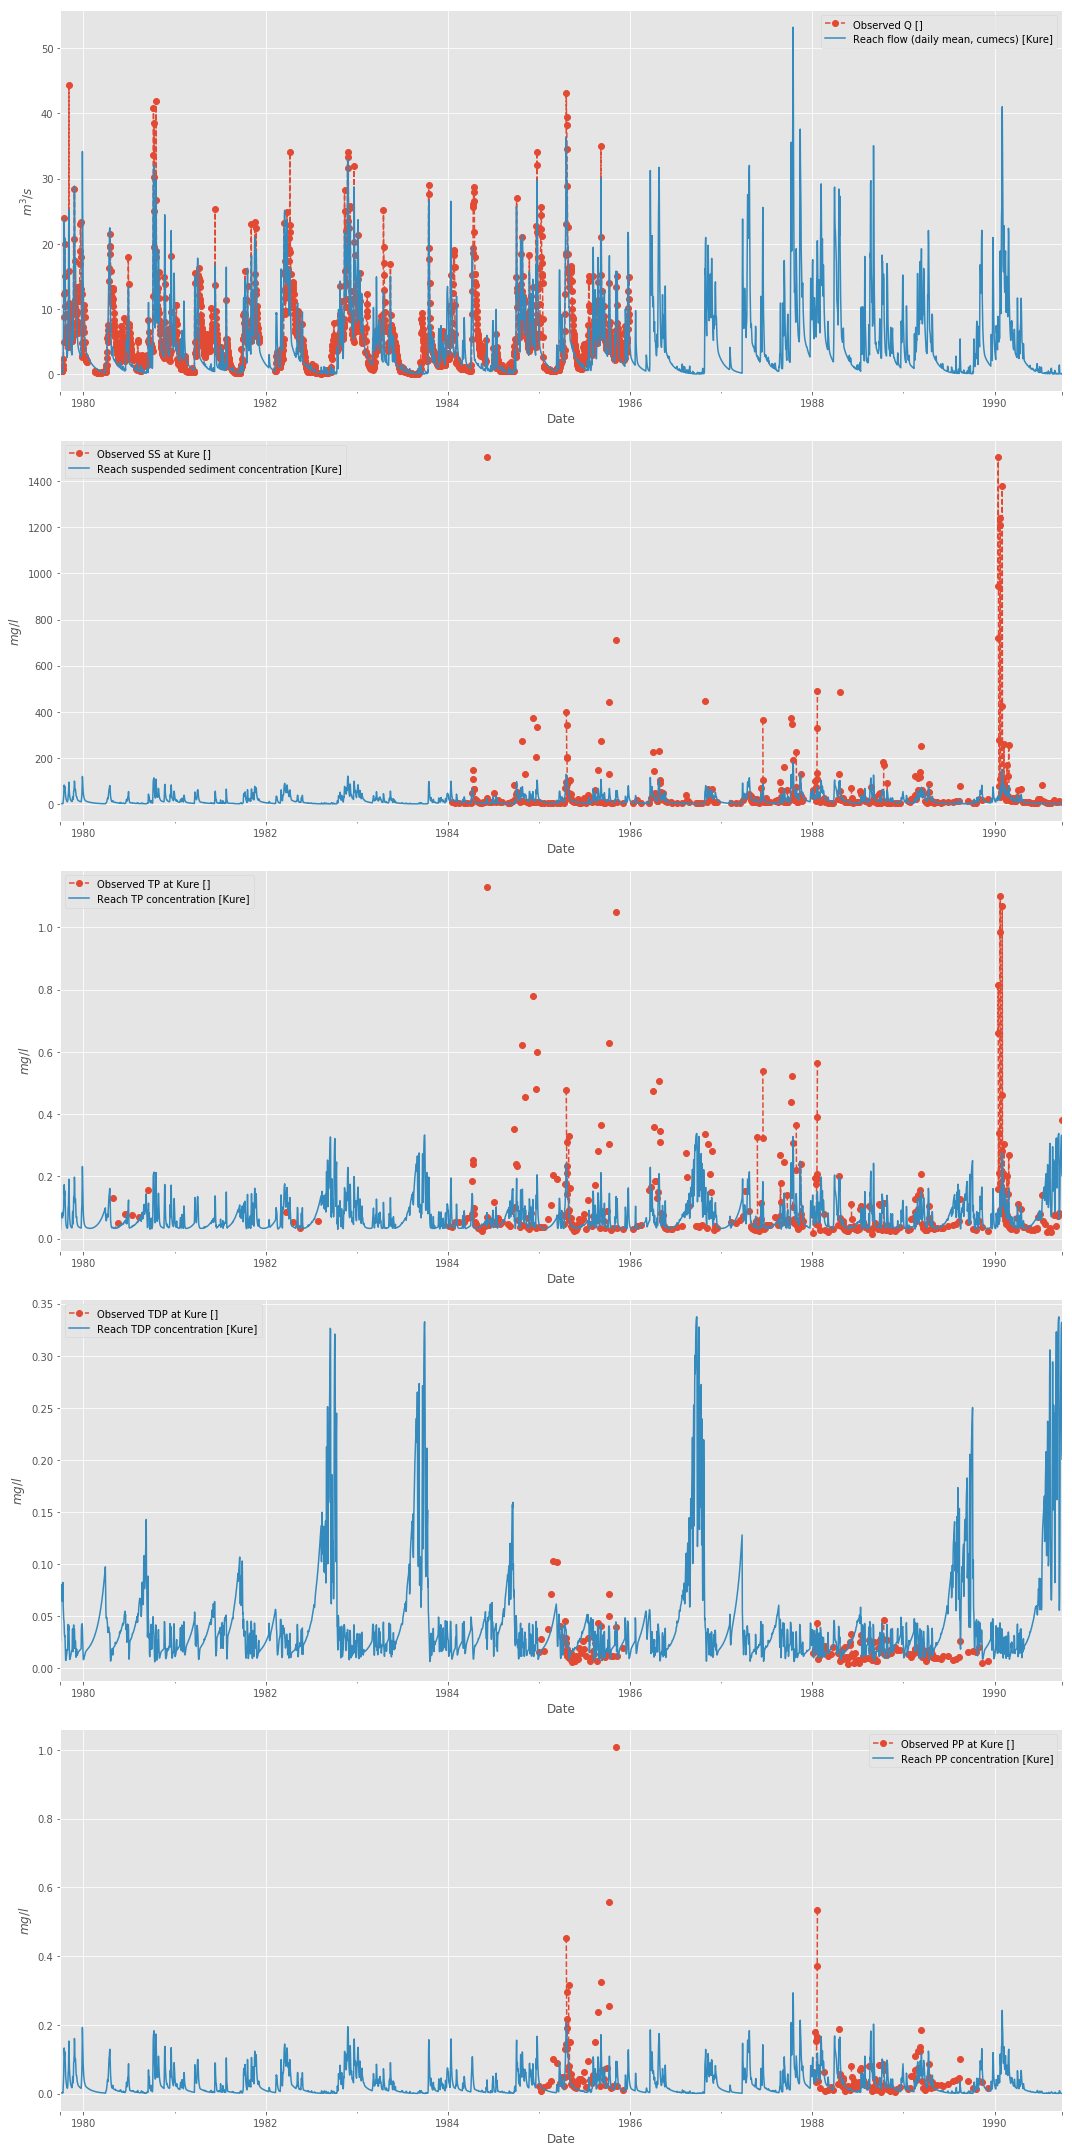

In [4]:
# Plot results from manual calibration
dataset.run_model()
cu.plot_objective(dataset, comparisons)

## 4. Choose parameters to calibrate

Parameter values should be informed by system knowledge wherever possible. The basic SimplyP dataset for Morsa provides some suggested parameter values and prior ranges, but it is a good idea to refine these if you can.

The code below lists default values and prior ranges for all the `'double'` parameters defined in the model. These are the ones available for calibration.

In [5]:
# Get parameter values defined in 'dataset'
param_df = cu.get_double_parameters_as_dataframe(dataset)
param_df

name           unit  \
0                                            Latitude              °   
1              Initial snow depth as water equivalent             mm   
2                      Degree-day factor for snowmelt      mm/°C/day   
3   Proportion of precipitation that contributes t...  dimensionless   
4                           PET multiplication factor  dimensionless   
5                                 Soil field capacity             mm   
6                                      Baseflow index  dimensionless   
7                           Groundwater time constant           days   
8                            Minimum groundwater flow         mm/day   
9   Gradient of reach velocity-discharge relationship         m^{-3}   
10  Exponent of reach velocity-discharge relationship  dimensionless   
11                                     Catchment area           km^2   
12                                       Reach length              m   
13                             Initial in-stream flow          m^3/s   
14                           Soil water time constant           days   
15                           Soil water time constant           days   
16                           Soil water time constant           days   
17                               Land use proportions  dimensionless   
18                               Land use proportions  dimensionless   
19                               Land use proportions  dimensionless   
20                Reach sediment input scaling factor          kg/mm   
21              Sediment input non-linear coefficient  dimensionless   
22                                        Reach slope              °   
23                   Proportion of spring grown crops  dimensionless   
24             Mean slope of land in the subcatchment              °   
25             Mean slope of land in the subcatchment              °   
26             Mean slope of land in the subcatchment              °   
27                            Vegetation cover factor  dimensionless   
28                            Vegetation cover factor  dimensionless   
29                            Vegetation cover factor  dimensionless   
30                      Reduction of load in sediment  dimensionless   
31                      Reduction of load in sediment  dimensionless   
32                      Reduction of load in sediment  dimensionless   
33                                   Soil mass per m2         kg/m^2   
34                   Phosphorous sorption coefficient          mm/kg   
35            Net annual P input to agricultural soil     kg/ha/year   
36         Net annual P input to newly-converted soil     kg/ha/year   
37                      Groundwater TDP concentration           mg/l   
38                    Particulate P enrichment factor  dimensionless   
39                                       SRP fraction  dimensionless   
40                          Reach effluent TDP inputs         kg/day   
41      Initial soil water TDP concentration and EPC0           mg/l   
42      Initial soil water TDP concentration and EPC0           mg/l   
43      Initial soil water TDP concentration and EPC0           mg/l   
44                       Initial total soil P content          mg/kg   
45                       Initial total soil P content          mg/kg   
46                       Initial total soil P content          mg/kg   
47          Land use proportions from newly-converted  dimensionless   
48          Land use proportions from newly-converted  dimensionless   
49          Land use proportions from newly-converted  dimensionless   

                         index  min_value  initial_value    max_value  
0                           ()  -90.00000      59.600000        90.00  
1                           ()    0.00000       0.000000     50000.00  
2                           ()    0.00000       2.740000         5.00  
3                           ()    0.00000       0.020000         1.00  
4               

We will choose to calibrate a sub-set of these parameters (the ones that are most uncertain).

**Note:** Several methods can be used to subset the above dataframe. Consider using `'df.query'` to explicitly select parameters by name and index, rather than the rough row number selection used below.

In [6]:
# Get params to be calibrated
calib_df = param_df.loc[[2, 3, 4, 6, 7, 16, 20, 41, 37, 38, 40]].reset_index(drop=True)
calib_df

name           unit  \
0                      Degree-day factor for snowmelt      mm/°C/day   
1   Proportion of precipitation that contributes t...  dimensionless   
2                           PET multiplication factor  dimensionless   
3                                      Baseflow index  dimensionless   
4                           Groundwater time constant           days   
5                            Soil water time constant           days   
6                 Reach sediment input scaling factor          kg/mm   
7       Initial soil water TDP concentration and EPC0           mg/l   
8                       Groundwater TDP concentration           mg/l   
9                     Particulate P enrichment factor  dimensionless   
10                          Reach effluent TDP inputs         kg/day   

              index  min_value  initial_value  max_value  
0                ()       0.00           2.74        5.0  
1                ()       0.00           0.02        1.0  
2                ()       0.00           0.70        1.0  
3                ()       0.00           0.40        1.0  
4                ()       0.50          30.00      400.0  
5   (Semi-natural,)       0.05           3.00       40.0  
6                ()       0.00       11000.00   100000.0  
7         (Arable,)       0.00           0.15       10.0  
8                ()       0.00           0.01       10.0  
9                ()       1.00           1.50        5.0  
10          (Kure,)       0.00           2.00       10.0

In [7]:
# Add 'short_name' column for calibrating parameters
calib_df['short_name'] = ['DDFmelt',
                          'fquick',
                          'alphaPET',
                          'BFI',
                          'T_gw',
                          'Ts_SN',
                          'k_sed',
                          'TDP_sw',
                          'TDP_gw',
                          'E_PP',
                          'TDPeff',
                          ]

In [8]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)

In [9]:
# Optionally refine prior ranges
params['DDFmelt'].min = 0.5
params['DDFmelt'].max = 4

params['fquick'].min = 0.002
params['fquick'].max = 0.2

params['alphaPET'].min = 0.5
params['alphaPET'].max = 1

params['BFI'].min = 0.1
params['BFI'].max = 0.6

params['T_gw'].min = 15
params['T_gw'].max = 100

params['Ts_SN'].min = 1
params['Ts_SN'].max = 15

params['k_sed'].min = 500
params['k_sed'].max = 50000

params['TDP_sw'].min = 0.05
params['TDP_sw'].max = 0.2

params['TDP_gw'].min = 0.001
params['TDP_gw'].max = 0.03

params['E_PP'].min = 1
params['E_PP'].max = 4

params['TDPeff'].min = 0.05
params['TDPeff'].max = 3.5

In [10]:
params.pretty_print(columns=['value', 'min', 'max', 'vary'])

Name         Value      Min      Max     Vary
BFI            0.4      0.1      0.6     True
DDFmelt       2.74      0.5        4     True
E_PP           1.5        1        4     True
TDP_gw        0.01    0.001     0.03     True
TDP_sw        0.15     0.05      0.2     True
TDPeff           2     0.05      3.5     True
T_gw            30       15      100     True
Ts_SN            3        1       15     True
alphaPET       0.7      0.5        1     True
fquick        0.02    0.002      0.2     True
k_sed      1.1e+04      500    5e+04     True


## 5. Least squares optimisation

LMFit provides a convenient API to several Python optimisers (see [here](https://lmfit.github.io/lmfit-py/fitting.html#the-minimize-function) for details). 

Some of the optimisers also provide confidence intervals and correlations for the "best" parameters. These are approximate, but they provide useful information about the model and may help to refine parameter ranges (or even the model structure) before undertaking a more comprehensive calibration exercise using MCMC (see below).

In [11]:
%%time
# Minimise using Levenberg–Marquardt (gives similar output to Nelder-Mead, 
# but in this case it's faster)
mi, res = cu.minimize_residuals(params, dataset, comparisons, method='leastsq', norm=True, 
                                skip_timesteps=30)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 316
    # data points      = 3205
    # variables        = 11
    chi-square         = 4238.46446
    reduced chi-square = 1.32700828
    Akaike info crit   = 917.762106
    Bayesian info crit = 984.559247
[[Variables]]
    DDFmelt:   1.84161609 +/- 0.04498057 (2.44%) (init = 2.74)
    fquick:    0.00200016 +/- 0.23360932 (11679.54%) (init = 0.02)
    alphaPET:  0.61718489 +/- 0.00656644 (1.06%) (init = 0.7)
    BFI:       0.59999988 +/- 0.21829605 (36.38%) (init = 0.4)
    T_gw:      25.2588343 +/- 2.34810515 (9.30%) (init = 30)
    Ts_SN:     1.23602935 +/- 0.15125884 (12.24%) (init = 3)
    k_sed:     26705.8386 +/- 1120.45851 (4.20%) (init = 11000)
    TDP_sw:    0.14537432 +/- 0.01962135 (13.50%) (init = 0.15)
    TDP_gw:    0.01205981 +/- 0.00250478 (20.77%) (init = 0.01)
    E_PP:      1.06285347 +/- 0.06136866 (5.77%) (init = 1.5)
    TDPeff:    0.41257761 +/- 0.24204113 (58.67%)

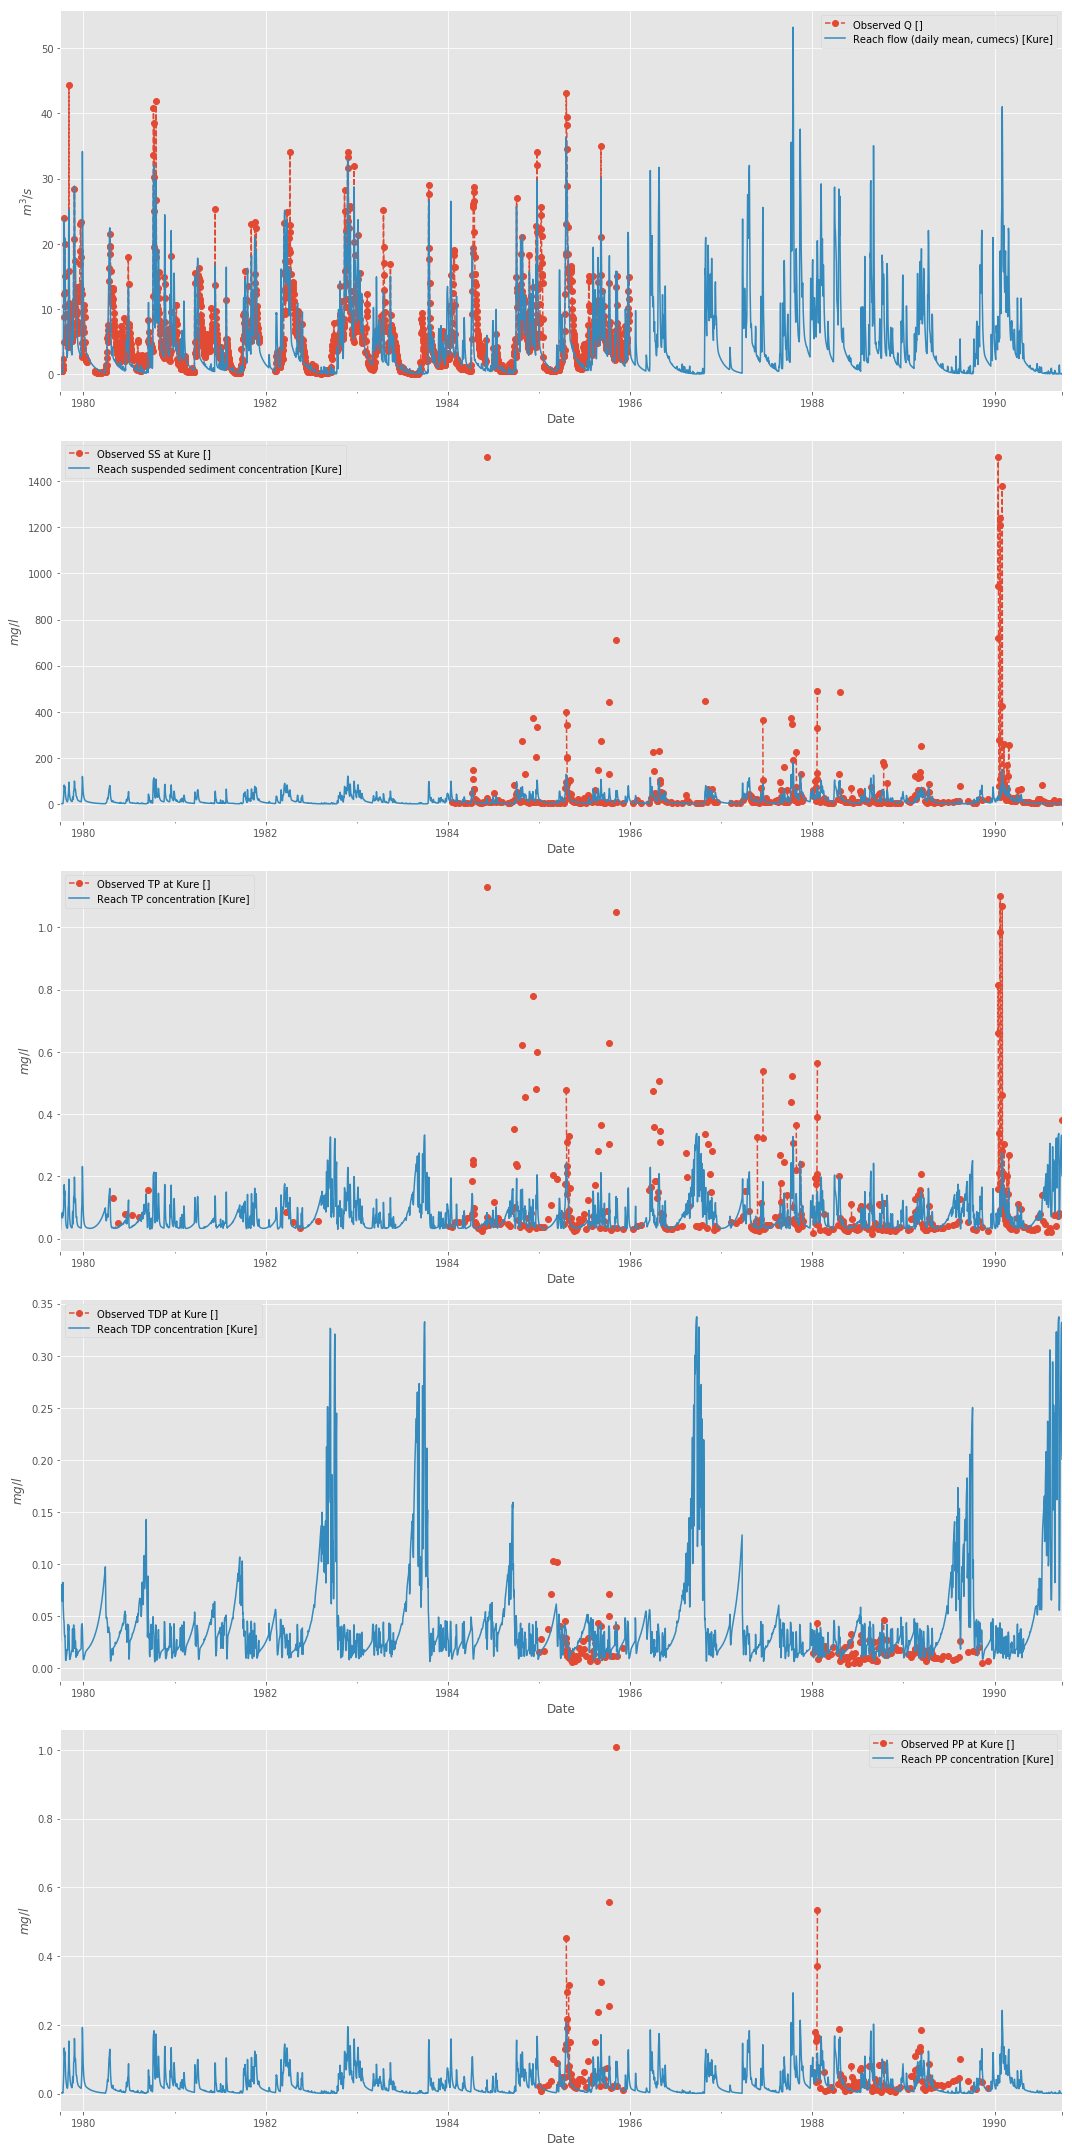

In [12]:
# Plot results from optimisation
cu.set_parameter_values(mi.params, dataset)
dataset.run_model()
cu.plot_objective(dataset, comparisons)

## 6. Full calibration and uncertainty analysis using MCMC

### 6.1. Likelihood function and error terms

Add additional parameters to represent the error structure. Parameters can be limnked, or calculated from others using the `'expr'` argument - see [here](https://lmfit.github.io/lmfit-py/constraints.html) for further details.

In [13]:
# Add error params
mi.params.add('err_q', value=0.5, min=0.05, max=3)
mi.params.add('err_ss', value=0.5, min=0.05, max=5)
mi.params.add('err_tp', value=0.5, min=0.05, max=2)
mi.params.add('err_tdp', expr='err_tp')             # Use a single error term for all P types
mi.params.add('err_pp', expr='err_tp')              # Use a single error term for all P types 

mi.params.pretty_print(columns=['value', 'min', 'max', 'vary'])

Name         Value      Min      Max     Vary
BFI            0.4      0.1      0.6     True
DDFmelt       2.74      0.5        4     True
E_PP           1.5        1        4     True
TDP_gw        0.01    0.001     0.03     True
TDP_sw        0.15     0.05      0.2     True
TDPeff           2     0.05      3.5     True
T_gw            30       15      100     True
Ts_SN            3        1       15     True
alphaPET       0.7      0.5        1     True
err_pp         0.5     -inf      inf    False
err_q          0.5     0.05        3     True
err_ss         0.5     0.05        5     True
err_tdp        0.5     -inf      inf    False
err_tp         0.5     0.05        2     True
fquick        0.02    0.002      0.2     True
k_sed      1.1e+04      500    5e+04     True


Note the `'vary=False'` entries for `'err_tdp'` and `'err_pp'`. This is because we have tied these parameters to `'err_tp'`, which does vary.

In [14]:
# Link error params to model datasets
error_param_dict = {'Observed Q':          'err_q',
                    'Observed SS at Kure': 'err_ss',
                    'Observed TP at Kure': 'err_tp',
                    'Observed TDP at Kure':'err_tdp',
                    'Observed PP at Kure': 'err_pp',
                   }

### 6.2. MCMC options

In [15]:
# Paths to model setup files
dataset_params_dat = '../../Applications/SimplyP/%s/%sParameters.dat' % (catchment, catchment)
dataset_input_dat = '../../Applications/SimplyP/%s/%sInputs.dat' % (catchment, catchment)
    
# emcee setup
nworkers = 8
ntemps = 1      
nsteps = 1000
nwalk = 100
nburn = 500
thin = 1

skip_timesteps = 30

# Result file paths
result_path = r'pickled\\mcmc_settings.pkl'
chain_plot_path = r'simplyp_plots\chains_test.png'
corner_plot_path = r'simplyp_plots\corner_test.png'

In [16]:
# Save settings for passing to MCMC
settings_dict = {'params':mi.params,
                 'error_param_dict':error_param_dict,
                 'dataset_params_dat':dataset_params_dat,
                 'dataset_input_dat':dataset_input_dat,
                 'comparisons':comparisons,
                 'skip_timesteps':skip_timesteps,
                 'nworkers':nworkers,
                 'ntemps':ntemps,
                 'nsteps':nsteps,
                 'nwalk':nwalk,
                 'nburn':nburn,
                 'thin':thin,
                 'result_path':result_path,
                 'chain_path':chain_plot_path,
                 'corner_path':corner_plot_path,                 
                }

with open('pickled\\mcmc_settings.pkl', 'wb') as handle:
    pickle.dump(settings_dict, handle)

### 6.3. Run MCMC

Time elapsed running emcee: 81.11 minutes.

Quantiles:
[(0.025, 1.0344908810078912), (0.5, 1.074865738425054), (0.975, 1.1217310774432079)]
Quantiles:
[(0.025, 0.008173009941821225), (0.5, 0.01667764562842513), (0.975, 0.024823321670301383)]
Quantiles:
[(0.025, 0.5652700856895181), (0.5, 0.5728137887627205), (0.975, 0.5797683153576275)]
Quantiles:
[(0.025, 0.2707949877718031), (0.5, 0.3068488898236852), (0.975, 0.35530050145998815)]
Quantiles:
[(0.025, 36.108094630324395), (0.5, 39.78564395218243), (0.975, 44.49533081512903)]
Quantiles:
[(0.025, 8.899495020991095), (0.5, 12.405495839641564), (0.975, 14.427821138292408)]
Quantiles:
[(0.025, 20849.633919182656), (0.5, 28003.27265207134), (0.975, 35371.48912615469)]
Quantiles:
[(0.025, 0.05027163463288378), (0.5, 0.05602132101466303), (0.975, 0.07497385541816705)]
Quantiles:
[(0.025, 0.004575230963828357), (0.5, 0.008329198608253116), (0.975, 0.012887567062361672)]
Quantiles:
[(0.025, 1.0293654039047577), (0.5, 1.2796115689194338), (0.975

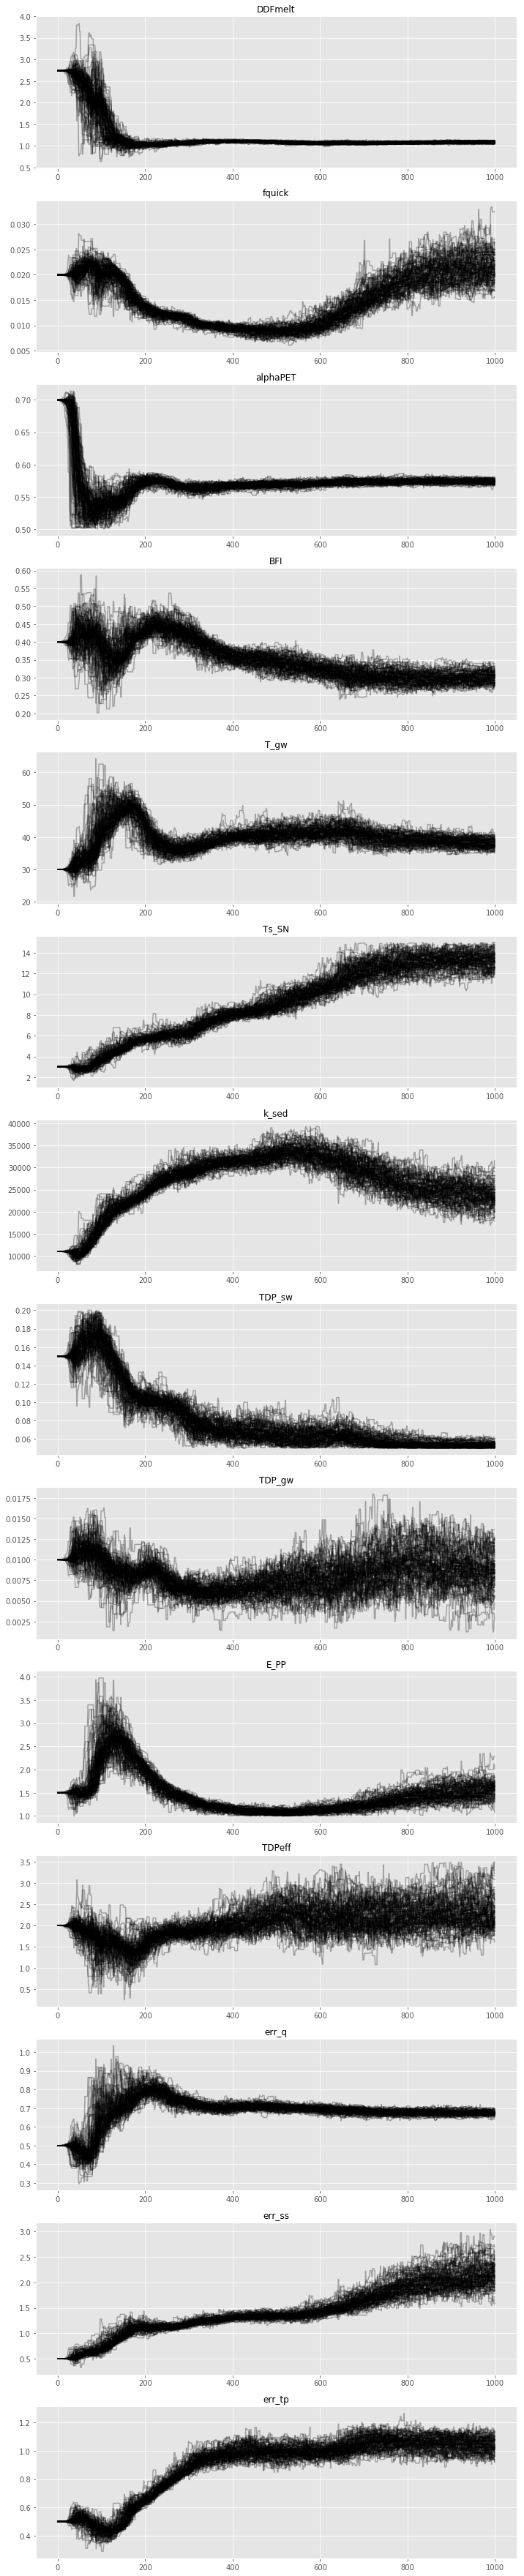

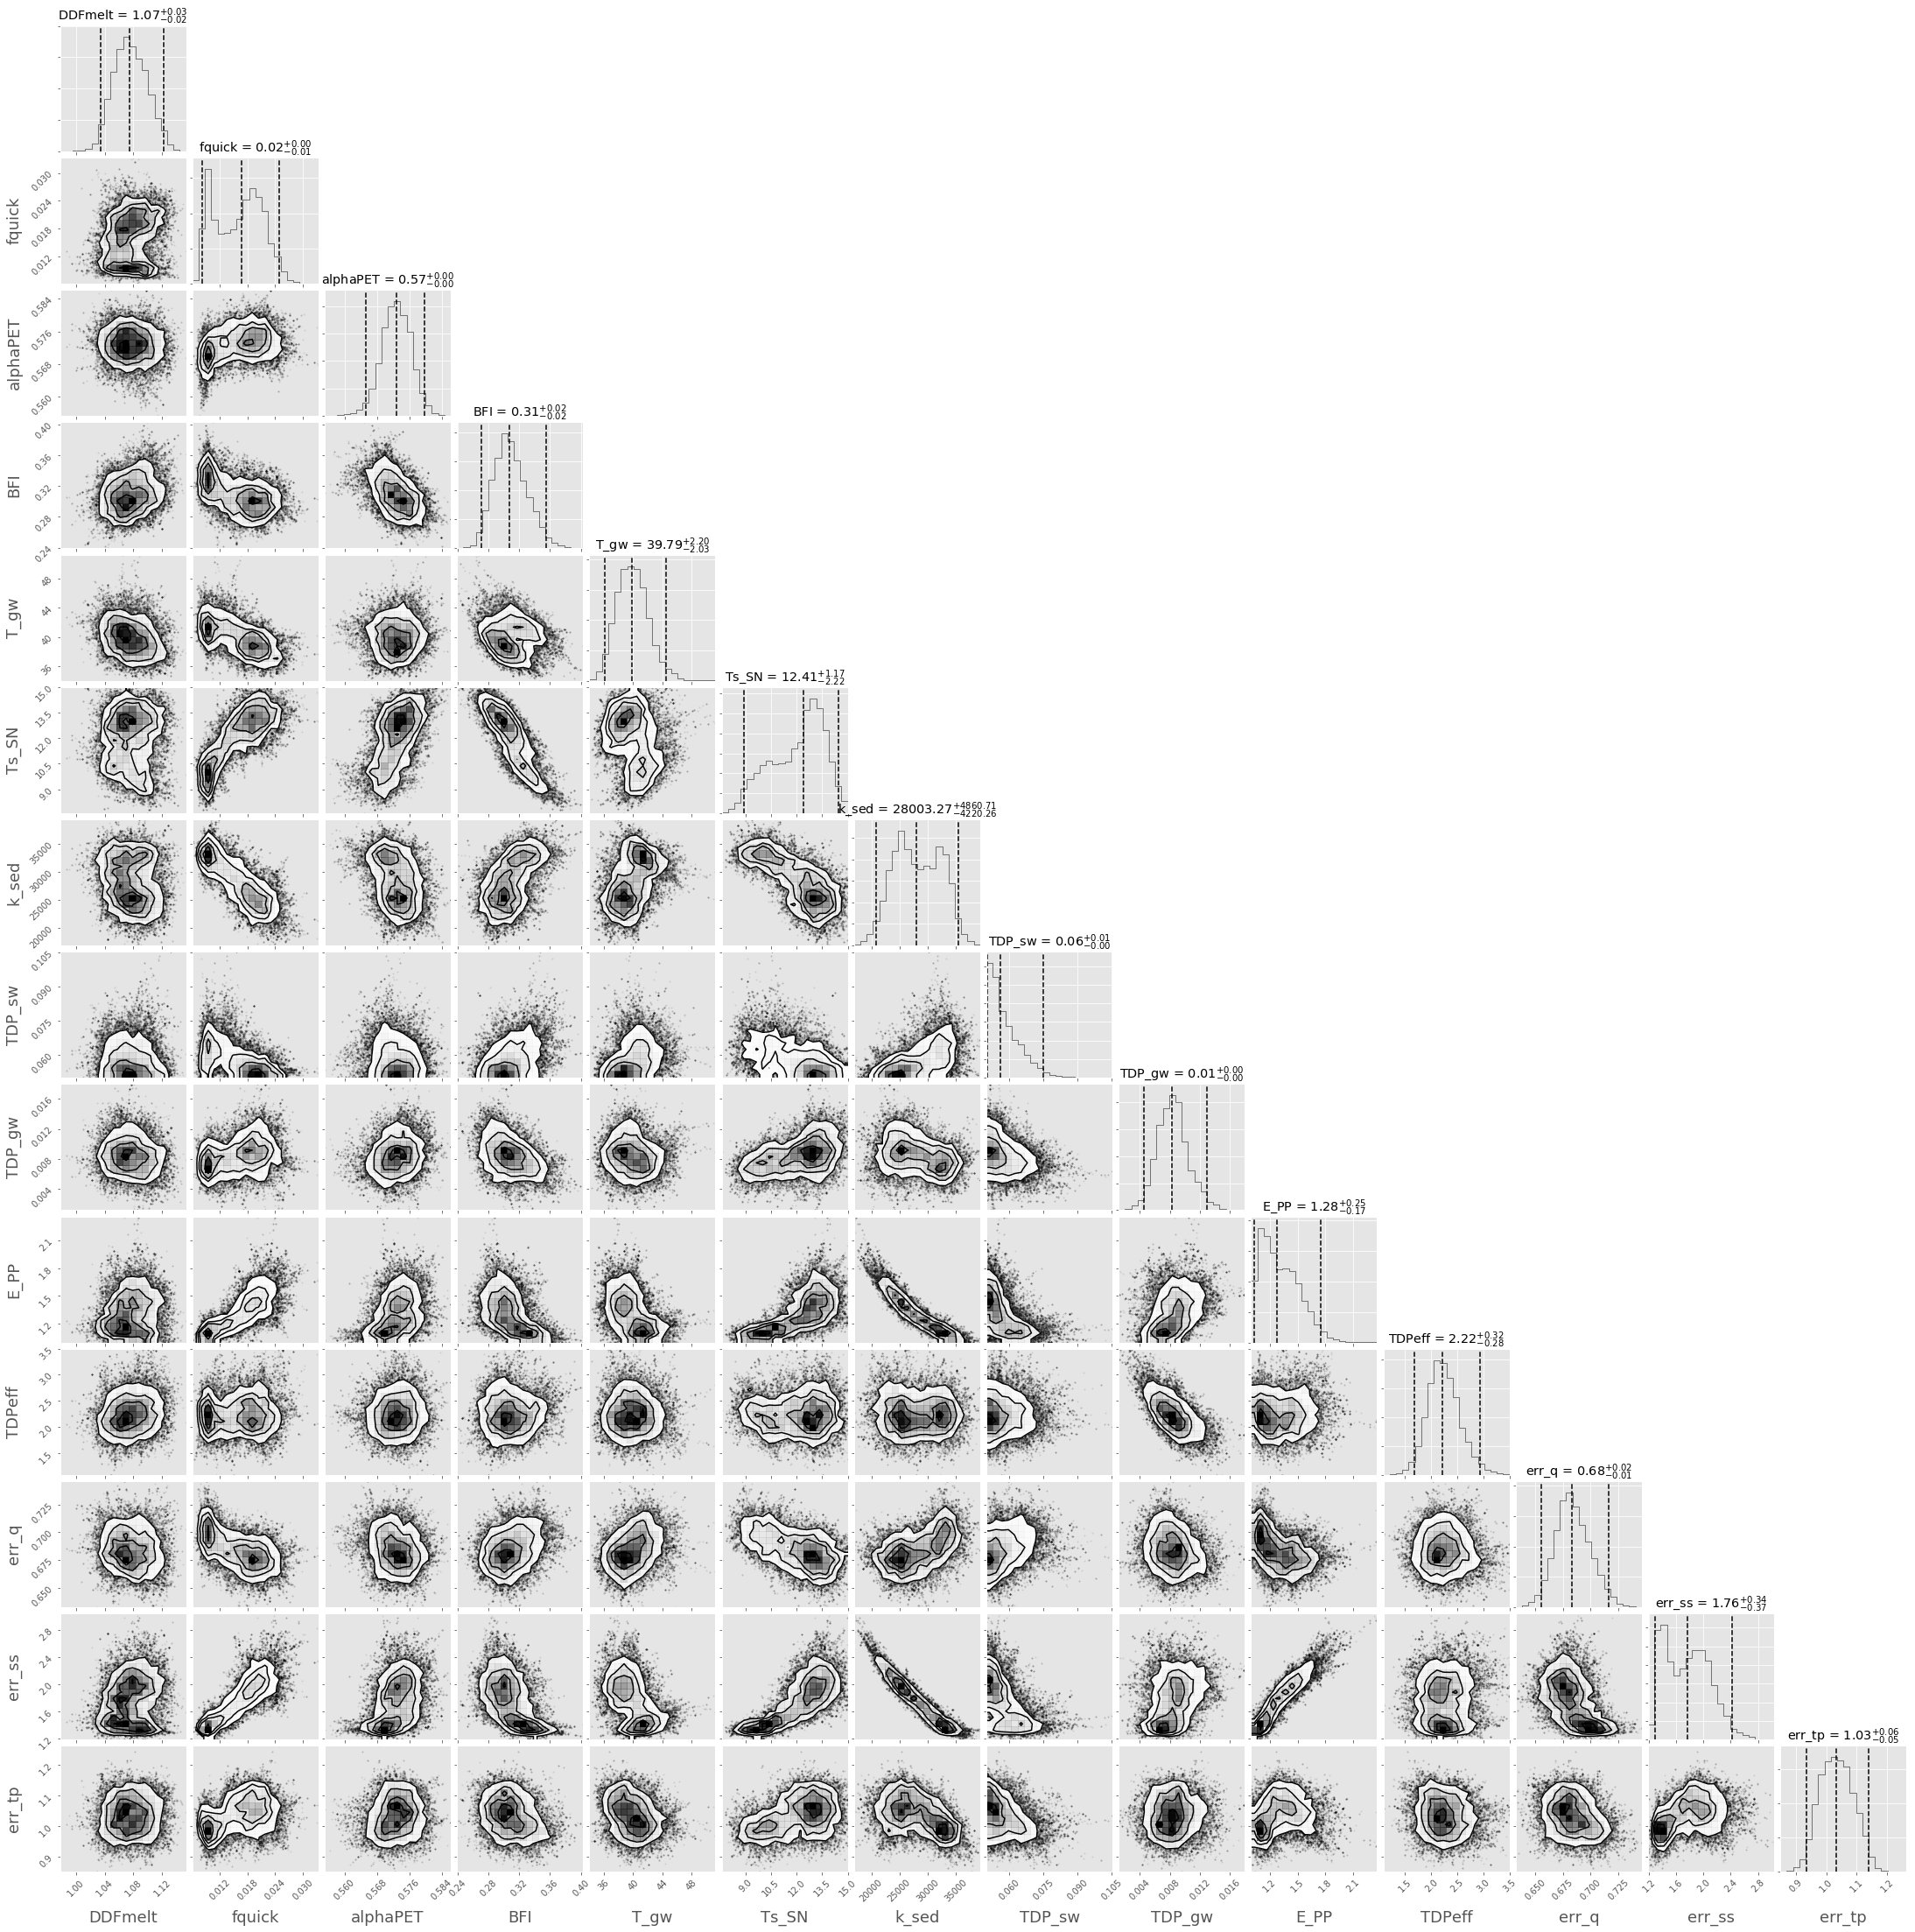

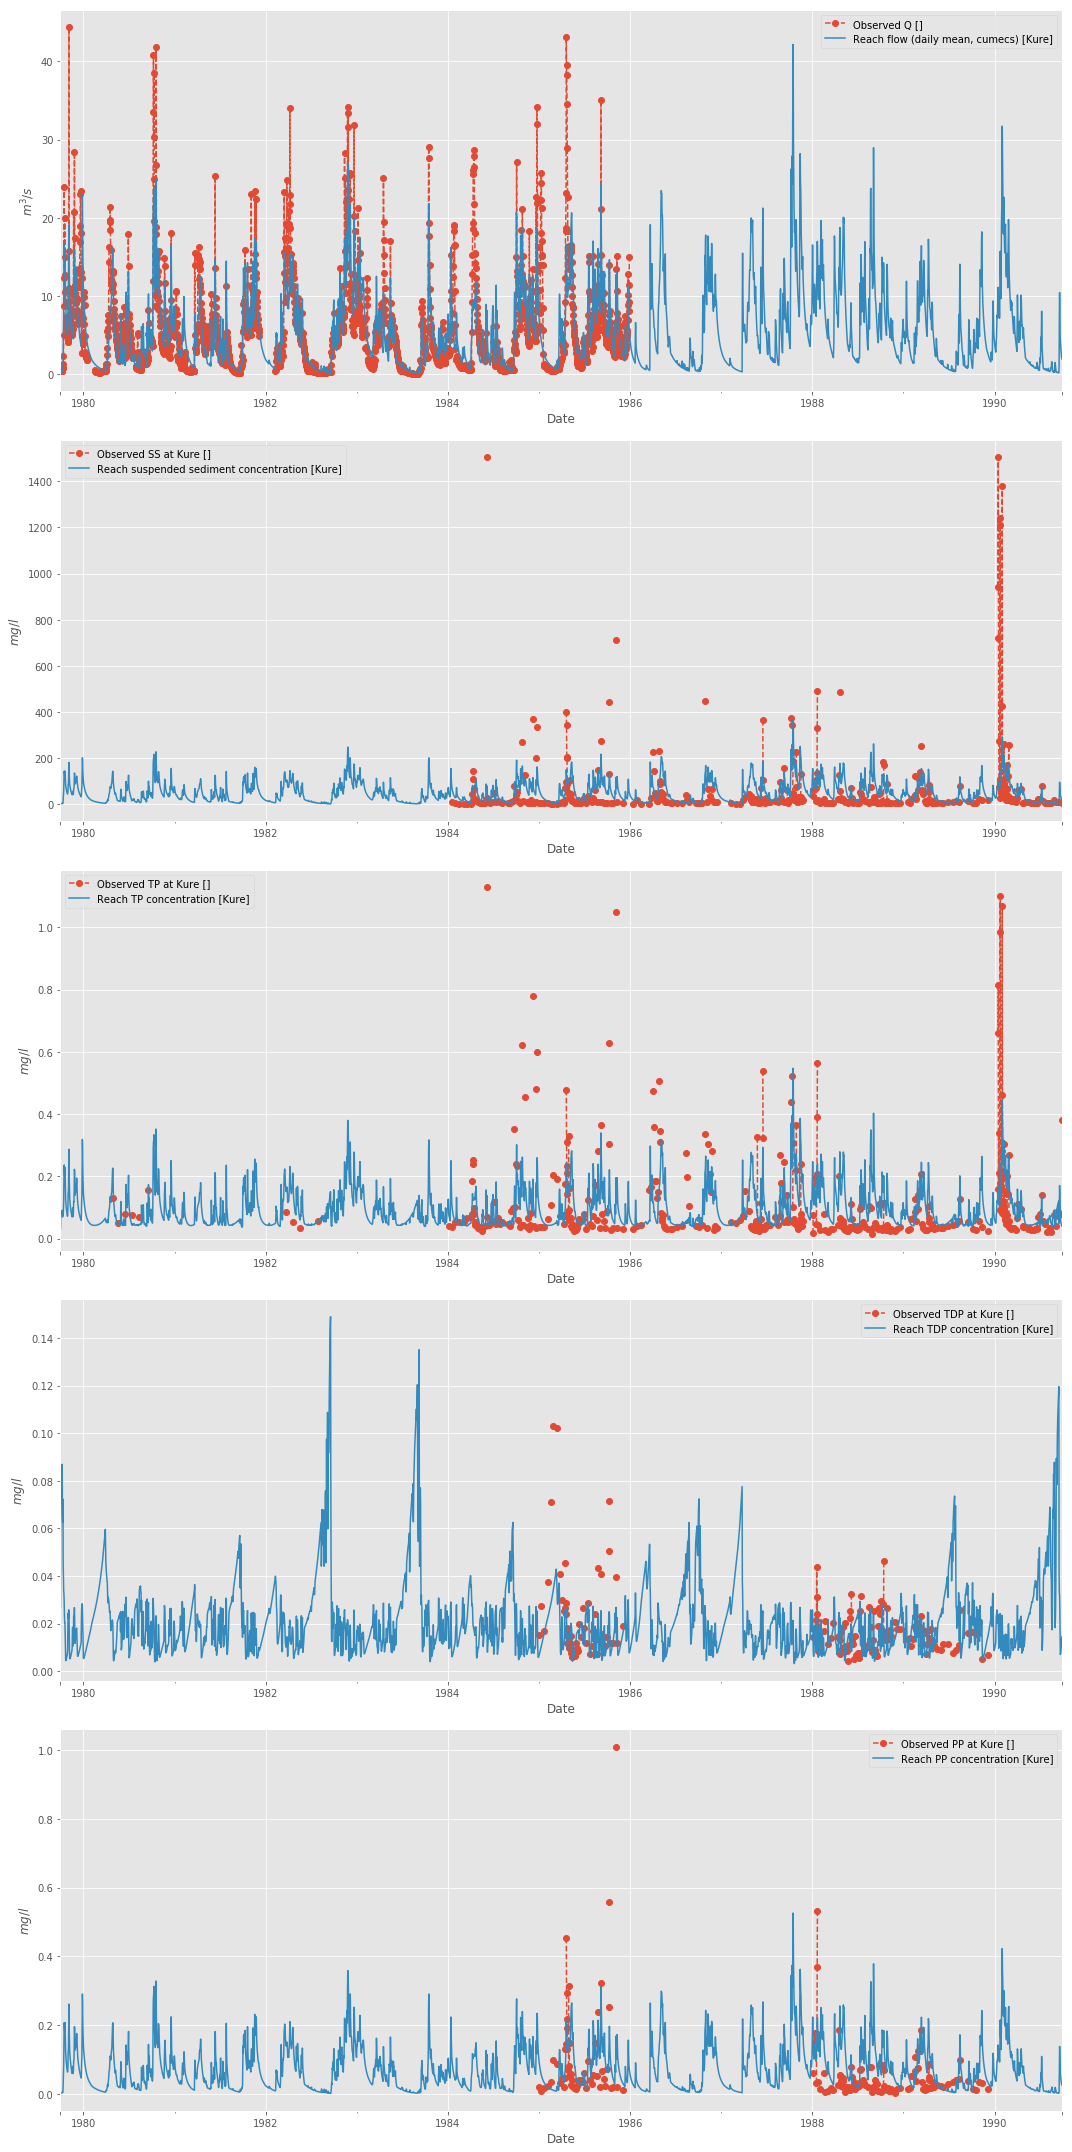

In [17]:
%run -i calibration_and_uncertainty.py